# Classificación (añade el nombre de tu tfm)

 Nombre: __Angie Galarza Chacón__

## Contexto

### Objetivo

El objetivo principal es desarrollar modelos basados en el aprendizaje automático para
clasificar con precisión cancer en celulas.

### Hardware

Para resolver este problema se ha utilizado diferentes librerías, las principales a destacar
son: Tensorflow, Keras, Numpy y Matplotlib.
La versión de Tensorflow es la 2.4.1. Se utiliza un enviroment conda que se ejecuta sobre
la versión 3.6 de Python. El código se encuentra disponible en el Jupyter Notebook
adjunto a este informe.
El hardware que se ha usado es una GPU GeForce RTX 2080 SUPER

### 1. Librerías

In [1]:
# All rellevant imports
import tensorflow as tf

print("TF version   : ", tf.__version__)
# we'll need GPU!
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# keras version is 2.4.3
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.4.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  2.4.3


In [2]:
from tensorflow.python.client import device_lib
print(tf.test.gpu_device_name())

local_prot = device_lib.list_local_devices()
print([x.physical_device_desc for x in local_prot if x.device_type == 'GPU'])

/device:GPU:0
['device: 0, name: GeForce RTX 2080 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5']


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D)
from keras.layers.experimental.preprocessing import Resizing

from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam
from keras import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras import applications
from tensorflow.keras.layers import Lambda
from tensorflow.image import resize
from keras.applications.resnet import preprocess_input
import tensorflow_addons as tfa
from keras import Input

In [4]:
%pylab inline
import cv2
import glob
import os
import pandas as pd
import matplotlib.pylab as plt

from matplotlib import image
from matplotlib import pyplot
from keras.models import Sequential, load_model

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


B:\software\miniConda\envs\models\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['resize']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import itertools

### 2. Exploración del dataset

En este apartado exploraremos la base de datos y prepararemos la carga de las imágenes
para los modelos de los siguientes apartados.

Las imágenes se encuentran en el path “data/images/” y se dan en formato ".tif".
Cada subdirectorio tiene el nombre de la categoría: C0 y C1.

In [6]:

ROOT_DIR = os.path.abspath("")
data_dir = os.path.join(ROOT_DIR, "train")


In [7]:
# preprossador del dataset para separar las diferentes clases
# en el set de trainning c0 y c1 debido a que vienen los 
#labels en un fichero  .csv

# def manage_files():
#     csv = [x for x in os.listdir(ROOT_DIR) if x.endswith(".csv")]
#     return csv

# df = manage_files()

# csv_file = pd.read_csv(df[2], sep=',')

# c0 = [x for x in csv_file[csv_file['label'] == 0]['id']]
# c1 = [x for x in csv_file[csv_file['label'] == 1]['id']]


# folder0 = os.path.join(data_dir, "c0")
# os.mkdir(folder0)
# folder1 = os.path.join(data_dir, "c1")
# os.mkdir(folder1)

# for key in c0:
#     os.rename(os.path.join(data_dir, key + ".tif"), os.path.join(folder0, key  + ".tif"))
# for key in c1:
#     os.rename(os.path.join(data_dir, key + ".tif"), os.path.join(folder1, key  + ".tif"))

In [8]:

NUM_IMG_TO_SHOW = 2
subdirs = [os.path.join(data_dir, x) for x in os.listdir(data_dir)]
labels_name = [x for x in os.listdir(data_dir)]



In [9]:
subdirs = [os.path.join(data_dir, x) for x in os.listdir(data_dir)]
labels_name = [x for x in os.listdir(data_dir)]
total, category_image = [], []
folders = []
for subdir in subdirs:
    total.append(len(os.listdir(subdir)))
    category_image.append(os.path.join(subdir, os.listdir(subdir)[0]))


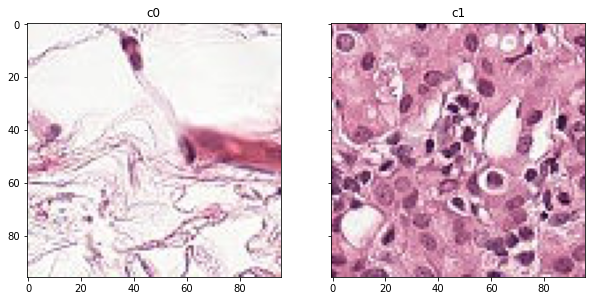

In [10]:

#pintamos las imagenes
from matplotlib import image
from matplotlib import pyplot

nrows = 1
ncols = int(len(labels_name)/nrows)

fig, ax = plt.subplots(nrows, ncols, figsize=(10,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)
for i, axi in enumerate(ax.flat):
    axi.imshow(image.imread(category_image[i]))
    axi.set_title(labels_name[i])



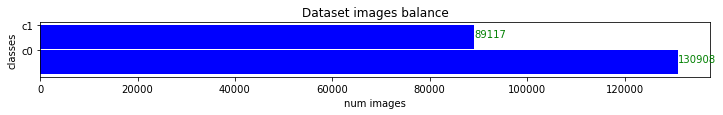

In [11]:
fig, ax = plt.subplots(figsize=(12,1))   
width = 0.95

ind = np.arange(len(total))
ax.barh(ind, total, width, color="blue")

ax.set_yticks(ind+width/2)
ax.set_yticklabels(labels_name)

plt.title('Dataset images balance')
plt.xlabel('num images')
plt.ylabel('classes')

percen = []
for i, v in enumerate(total):
    ax.text(v + 3, i, str(v), color='green',)
    percen.append((v, i))
plt.show()


In [12]:
total = sum([pair[0] for pair in percen])
for i in percen:
    print('Porcentaje de img de la clase C'+ str(i[1]) + ' '+ "{:.2f}".format(i[0] * 100 / total) + '%')

Porcentaje de img de la clase C0 59.50%
Porcentaje de img de la clase C1 40.50%


El conjunto de imágenes definidas para el entrenamiento contiene 220,025 imágenes. El set
se encuentra desbalanceado entre sus diferentes clases, en concreto la clase
C1 suma un total de 8,9117 imágenes que es equivalente al 40%
del total del dataset, mientras que la clase C0 contiene 130,908 imágenes equivalente al 59,50% del total del dataset.

### 2.3 preprocesado de los datos

Se establece los diferentes conjuntos de datos, para el set de entrenamiento usaremos el
80% y el 20% para el conjunto de validación.

In [13]:
HEIGHT = 96
WIDTH = 96

In [14]:
datagen = ImageDataGenerator(rotation_range=20,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                preprocessing_function=preprocess_input,
                                validation_split=0.2)

train = datagen.flow_from_directory(data_dir,
                                    shuffle=True,
                                    target_size=(HEIGHT, WIDTH),
                                    subset='training',
                                    class_mode='categorical')

val = datagen.flow_from_directory(data_dir,
                                    shuffle=False,
                                    target_size=(HEIGHT, WIDTH),
                                    subset='validation',
                                    class_mode='categorical')


Found 176021 images belonging to 2 classes.
Found 44004 images belonging to 2 classes.


El conjunto de imágenes test ya lo tenemos definido, imágenes separadas
en su set correspondiente sin especificar a que clase corresponden cada una.

Debido al desbalance del conjunto de datos, el conjunto de datos se aumenta, se realiza
mediante movimientos de volteo horizontales y vertical y diferentes ajustes de
brillo.

De este modo se obtiene un conjunto de datos equilibrado para cada clase. El aumento de
la imagen es una de las técnicas más conocidas para mejorar los resultados cuando el
conjunto de datos está desequilibrado. La biblioteca de redes neuronales de aprendizaje
profundo Keras proporciona la capacidad de ajustar modelos utilizando el aumento de
datos de imágenes a través de la clase ImageDataGenerator.

Una vez construido el objeto de ImageDataGenerator, creamos un iterador para el
conjunto de imágenes, devolverá un conjunto de imágenes aumentadas en cada iteración,
este iterador se ha cargado en memoria mediante la función flow_from_directory.

Se ha utilizado el iterador para entrenar un modelo de red neuronal llamando a la función
fit_generator. El argumento steps_per_epoch se ha especificado el número de grupos de
muestras que componen una época.

Alternativamente se planteó augmentación offline, la idea era crear un iterador para un
conjunto de datos de imágenes ubicado en el disco en un directorio especificado, pero
debido al gran tamaño que se podría generar se descartó este experimento.

## 3. Modelos (Transfer learning)

Las redes convolucionales profundas nos permiten aumentar la capacidad de aprendizaje
del modelo. Las arquitecturas comunes, pueden llegan a tener cientos de capas
convolucionales. Sin embargo, entrenar desde cero estas arquitecturas es costoso (en
tiempo y recursos), además de requerir conjuntos de datos bastante grandes.

Para intentar resolver este problema aplicaremos __transfer learning__. Esta metodología
consiste en aprovechar los pesos de un modelo entrenado en otra base de datos y para otra
tarea. En concreto, EfficientNetB0 y VGG16, los adaptaremos para clasificar las 2
diferentes categorías del dataset.

Se utilizarán diferentes métricas de rendimiento para evaluar y comparar los diferentes
modelos de redes neuronales utilizados, entre ellas se destaca:

__Accuracy__
Se utiliza en los problemas de clasificación y es una métrica de evaluación común de
evaluación. Se define como la relación entre el número de predicciones correctas
realizadas por el total predicciones realizadas.

__F1 score__
Combina la fórmula de la precisión y la recall en la relación con una clase positiva
especifica. La F1 score alcanza su mejor valor en uno y el peor en cero.

Se definen parámentros por defecto y funciones de tipo útil para facilitar obtener resultados:

In [15]:
NUM_CLASSES = len(labels_name) 
NUM_TRAIN = len(train.filenames)
NUM_VAL = len(val.filenames)
LR = 0.0001
EPOCHS = 10
BATCH_SIZE = 32
VERBOSE = 1

Functions para printar resultados:

In [16]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train acc', 'Val acc'], loc='upper right')
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epochs') 
    plt.legend(['Train loss', 'Val loss'], loc='upper right') 
    plt.show()
    
def plot_f1(history):
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score']) 
    plt.title('Model F1') 
    plt.ylabel('f1') 
    plt.xlabel('Epochs') 
    plt.legend(['Train f1', 'Val f1'], loc='upper right') 
    plt.show()
    
def plot_cm(cm):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)

    plt.title('Confusion matrix')
    fig.colorbar(cax)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],'d'),
                 horizontalalignment="center",
                 color="white", 
                 fontsize=12)

    ticks = np.arange(len(labels_name))
    plt.xticks(ticks, labels_name, rotation=90)
    plt.yticks(ticks, labels_name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Callbacks:

In [17]:
METRIC = "val_f1_score"
PATH = './model.h5'

def create_callbacks(metric = METRIC, path = PATH):
    checkpoint = ModelCheckpoint(
        filepath=path,
        monitor= metric,
        mode='max',
        save_best_only=True,
        verbose=1)

    reducelr = ReduceLROnPlateau(
        monitor= metric,
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0)

    eS = EarlyStopping(
        monitor= metric,
        mode='max',
        patience=5, 
        verbose=2)
    
    callbacks = [checkpoint, reducelr, eS]         
    return callbacks

Compile models function:

In [18]:
def compile_model(model, lr=LR):
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    loss = tf.keras.losses.CategoricalCrossentropy()
    
    metrics = [tfa.metrics.F1Score(num_classes = len(labels_name),average = "macro",name = "f1_score"), 
               'accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

### 3.1 Red convolucional profunda - VGG16

VGG es una de las clásicas redes convolucionales, que se basan en un análisis de como
aumentar la profundidad. existe la versión VGG-16 y VGG-19 (Simonyan y Zisserman,
2014). VGG-19 es una versión todavía más profunda que VGG-16, pero la precisión
obtenida por las dos es muy similar y normalmente se usa la red VGG-16. Por lo que para
este problema experimentará con la red VGG-16.

La red utiliza pequeños filtros de 3 x 3. Por lo demás, la red se caracteriza por su
simplicidad, los únicos componentes son las capas de agrupación y una capa totalmente
conectada. VGG tiene una arquitectura bastante uniforme, las capas convolucionales
siguen con capas de pooling que reducen el alto y ancho de los volúmenes. Además, si
nos fijamos en el número de filtros que se usan en cada convolución, sus valores son: 64,
128, 256 y 512. Es decir, el valor se duplica en cada paso, creando un principio bastante
simple en el diseño de la arquitectura.

#### 3.1.1 Feature extraction

En este caso no se construirá un modelo VGG desde cero, ya que se requiere un espacio
de memoria y un ancho de banda considerablemente grandes, ya que el tamaño de los
pesos de VGG-16 entrenados en ImageNet es de 528 MB.

Aplicaremos feature extraction, es decir, utilizaremos los parámetros aprendidos para
extraer características, estas features de los nuevos se procesarán a través de un
clasificador que se entrena desde cero.

Adaptaremos el tamaño de la imagen a (96,96) y antes de entrenar el modelo,
indicaremos que las capas de la base convolucional no deben ser entrenadas, o en otras
palabras “congelamos capas”, (freeze layers). Congelar una capa o un conjunto de capas
significa evitar que sus pesos se actualicen durante el entrenamiento. Si no hiciéramos
esto, los valores que fueron previamente aprendidos por la base convolucional serían
modificados durante el entrenamiento, efecto que no buscamos.

In [19]:
def create_model_vgg():
    dropout = 0.001
    fc_layers = [1024, 1024]
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))
    num_classes = len(labels_name)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) # New FC layer, random init
        x = Dropout(dropout)(x)

    predictions = Dense(num_classes, activation='softmax')(x) # New softmax layer
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

In [20]:


model_vgg = create_model_vgg()
model_vgg = compile_model(model_vgg)
callbacks = create_callbacks(path='./model_vgg.h5')


In [21]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

Finalmente procedemos a entrenar el modelo con el método fit_generator durante 10
épocas con la misma configuración de Data Augmentation descrita anteriormente,
utilizando EarlyStopping, monitoreando la función de pérdida en el conjunto de
validación, monitoreando la métrica accuracy y F1 durante entrenamiento y validación y
haciendo uso del optimizador Adam con un learning rate inicial de 1-3e pero usando la
función ReduceLROnPlateau de Keras para reducir este rate cuando el training no esté
procesando.

In [22]:
history_vgg = model_vgg.fit_generator(train, 
                                    epochs=EPOCHS, 
                                    workers=16, 
                                    steps_per_epoch=NUM_TRAIN // BATCH_SIZE, 
                                    validation_data=val, 
                                    validation_steps=NUM_VAL // BATCH_SIZE,
                                    shuffle=True, 
                                    callbacks=callbacks)

Epoch 1/10
5500/5500 [==============================] - 206s 37ms/step - loss: 0.7901 - f1_score: 0.7909 - accuracy: 0.7998 - val_loss: 0.3436 - val_f1_score: 0.8462 - val_accuracy: 0.8536

Epoch 00001: val_f1_score improved from -inf to 0.84624, saving model to .\model_vgg.h5
Epoch 2/10
5500/5500 [==============================] - 189s 34ms/step - loss: 0.3474 - f1_score: 0.8429 - accuracy: 0.8499 - val_loss: 0.3173 - val_f1_score: 0.8585 - val_accuracy: 0.8648 f1_score: 0.8428 - accu - ETA: 2s - loss: 0.3475 - f1_score: 0.8428 - accuracy: 0.84 - ETA: 2s - loss: 

Epoch 00002: val_f1_score improved from 0.84624 to 0.85848, saving model to .\model_vgg.h5
Epoch 3/10
5500/5500 [==============================] - 192s 35ms/step - loss: 0.3235 - f1_score: 0.8545 - accuracy: 0.8610 - val_loss: 0.3085 - val_f1_score: 0.8634 - val_accuracy: 0.86940. - ETA: 0s - loss: 0.3235 - f1_score: 0.8545 - accuracy: 0.860 - ETA: 0s - loss: 0.3235 - f1_score: 0.8545 - accuracy: 0 - ETA: 0s - loss: 0.3235 -

#### 3.1.2 Resultados VGG

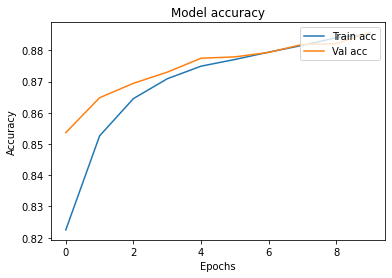

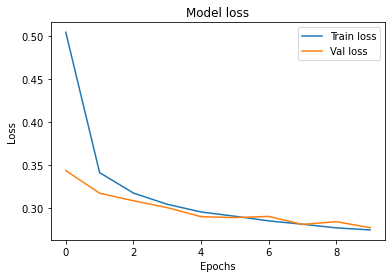

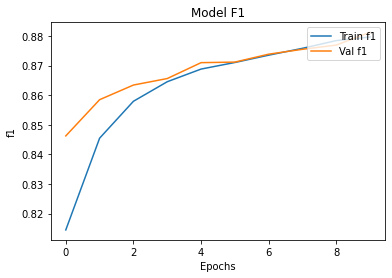

In [23]:
plot_accuracy(history_vgg)
plot_loss(history_vgg)
plot_f1(history_vgg)

In [24]:
val_pred=model_vgg.predict(val,verbose=0)
predicted_class_indices=np.argmax(val_pred,axis=1)

In [25]:
labels = (val.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
val_labels = [labels[k] for k in val.labels]

In [26]:

print(f'\n Report:\n {classification_report(val_labels, predictions)}')



 Report:
               precision    recall  f1-score   support

          c0       0.90      0.91      0.90     26181
          c1       0.86      0.85      0.86     17823

    accuracy                           0.88     44004
   macro avg       0.88      0.88      0.88     44004
weighted avg       0.88      0.88      0.88     44004



In [3]:
cmv = confusion_matrix(val_labels, predictions)
plot_cm(cmv)

NameError: name 'val_labels' is not defined

### 3.2 Red convolucional profunda - EfficientNetB0

EfficientNet, introducido por primera vez en Tan y Le, 2019, se encuentra entre los
modelos más eficientes (es decir, que requieren menos FLOPS para la inferencia) que
alcanzan una precisión de estado del arte tanto en tareas de aprendizaje de transferencia
de clasificación de imágenes como de imágenes comunes.

EfficientNet proporciona una familia de modelos (B0 a B7) que representa una buena
combinación de eficiencia y precisión en una variedad de escalas. Dicha heurística de
escalado (compound-scaling, detalles en Tan y Le, 2019) permite que el modelo base
orientado a la eficiencia (B0) supere a los modelos en todas las escalas, al tiempo que se
evita la búsqueda exhaustiva de hiperparámetros.

Según el reporte oficial, se puede tener la impresión de que EfficientNet es una familia
continua de modelos creados mediante la elección arbitraria del factor de escala. En
consecuencia, la profundidad, la anchura y la resolución de cada variante de los modelos
de EfficientNet se seleccionan a mano y se ha comprobado que producen buenos
resultados, aunque pueden desviarse significativamente de la fórmula de escalado
compuesto. Por lo tanto, para resolver el problema se utiliza la implementación de Keras
del modelo B0, este modelo toma imágenes de entrada de forma (96, 96, 3), y los datos
de entrada deben oscilar [0, 255]. La normalización se incluye como parte del modelo.

#### 3.2.1 Fine-tuning

En este caso tampoco se construirá un el modelo EfficientNetB0 desde cero. Volvemos
aplicaremos transfer learning, utilizaremos los conocimientos como los pesos y las
características del modelo EfficientNetB0 previamente entrenados para resolver este
problema.

Para este experimento, se utilizará otra técnica complementaria a la Feature Extraction,
el Fine-Tuning, que consiste en hacer un ajuste más fino y entrenar también algunas de
las capas de la base convolucional del modelo usado para la extracción de características
(que hasta ahora se mantenía congelado), y entrenar conjuntamente tanto la parte
agregada del clasificador como estas capas.

Primero descongelaremos las 20 capas superiores y dejamos las capas
BatchNormalization congeladas, antes de la salida añadiremos una capa
GlobalAveragePooling2D, una de BatchNormalization para la agrupación de promedios
en las dimensiones espaciales hasta que cada dimensión espacial sea una y la de Dropout
para prevenir el overfitting con el dropout rate de 0.2.


In [30]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

def build_model_effNet():
    num_classes = len(labels_name)
    inputs = layers.Input(shape=(HEIGHT, WIDTH, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

In [31]:


model_effNet = build_model_effNet()
model_effNet = compile_model(model_effNet)
callbacks = create_callbacks(path='./model_effnet.h5')



In [32]:
model_effNet.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 96, 96, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 96, 96, 3)    7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 97, 97, 3)    0           normalization_1[0][0]            
_______________________________________________________________________________________

Finalmente procedemos a entrenar el modelo con el método fit_generator durante 10
épocas con la misma configuración de Data Augmentation descrita anteriormente,
utilizando EarlyStopping, monitoreando la función de pérdida en el conjunto de
validación, monitoreando la métrica accuracy y F1 durante entrenamiento y validación y
haciendo uso del optimizador Adam con un learning rate inicial de 1-3e pero usando la
función ReduceLROnPlateau de Keras para reducir este rate cuando el training no esté
procesando.

In [33]:
history_eff = model_effNet.fit_generator(train, 
                                    epochs=EPOCHS, 
                                    workers=16,
                                    steps_per_epoch=NUM_TRAIN // BATCH_SIZE, 
                                    validation_data=val, 
                                    validation_steps=NUM_VAL // BATCH_SIZE,
                                    shuffle=True,
                                    callbacks=callbacks)

Epoch 1/10
5500/5500 [==============================] - 583s 105ms/step - loss: 0.4244 - f1_score: 0.8210 - accuracy: 0.8280 - val_loss: 0.1867 - val_f1_score: 0.9237 - val_accuracy: 0.9279

Epoch 00001: val_f1_score improved from -inf to 0.92370, saving model to .\model_effnet.h5
Epoch 2/10
5500/5500 [==============================] - 524s 95ms/step - loss: 0.2113 - f1_score: 0.9141 - accuracy: 0.9176 - val_loss: 0.1452 - val_f1_score: 0.9461 - val_accuracy: 0.9482

Epoch 00002: val_f1_score improved from 0.92370 to 0.94606, saving model to .\model_effnet.h5
Epoch 3/10
5500/5500 [==============================] - 487s 88ms/step - loss: 0.1728 - f1_score: 0.9326 - accuracy: 0.9353 - val_loss: 0.1271 - val_f1_score: 0.9528 - val_accuracy: 0.9546

Epoch 00003: val_f1_score improved from 0.94606 to 0.95279, saving model to .\model_effnet.h5
Epoch 4/10
5500/5500 [==============================] - 479s 87ms/step - loss: 0.1508 - f1_score: 0.9419 - accuracy: 0.9442 - val_loss: 0.1234 - val_f

#### 3.1.2 Resultados EFF0

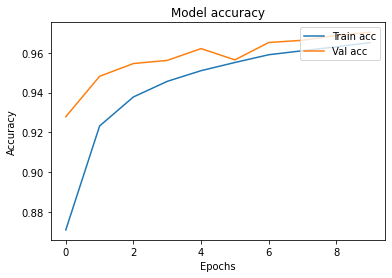

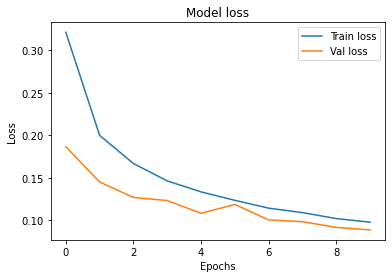

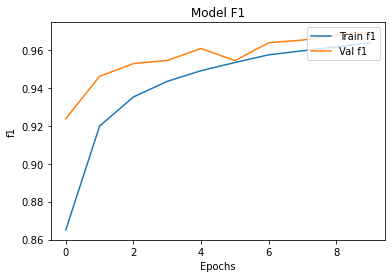

In [34]:
plot_accuracy(history_eff)
plot_loss(history_eff)
plot_f1(history_eff)

In [36]:
val_pred3=model_effNet.predict_generator(val,verbose=0)
predicted_class_indices3=np.argmax(val_pred3,axis=1)

In [38]:
val_labels = [labels[k] for k in val.labels]
predictions3 = [labels[k] for k in predicted_class_indices3]

In [39]:
print(f'\n Report:\n {classification_report(val_labels, predictions3)}')


 Report:
               precision    recall  f1-score   support

          c0       0.98      0.97      0.98     26181
          c1       0.96      0.97      0.96     17823

    accuracy                           0.97     44004
   macro avg       0.97      0.97      0.97     44004
weighted avg       0.97      0.97      0.97     44004



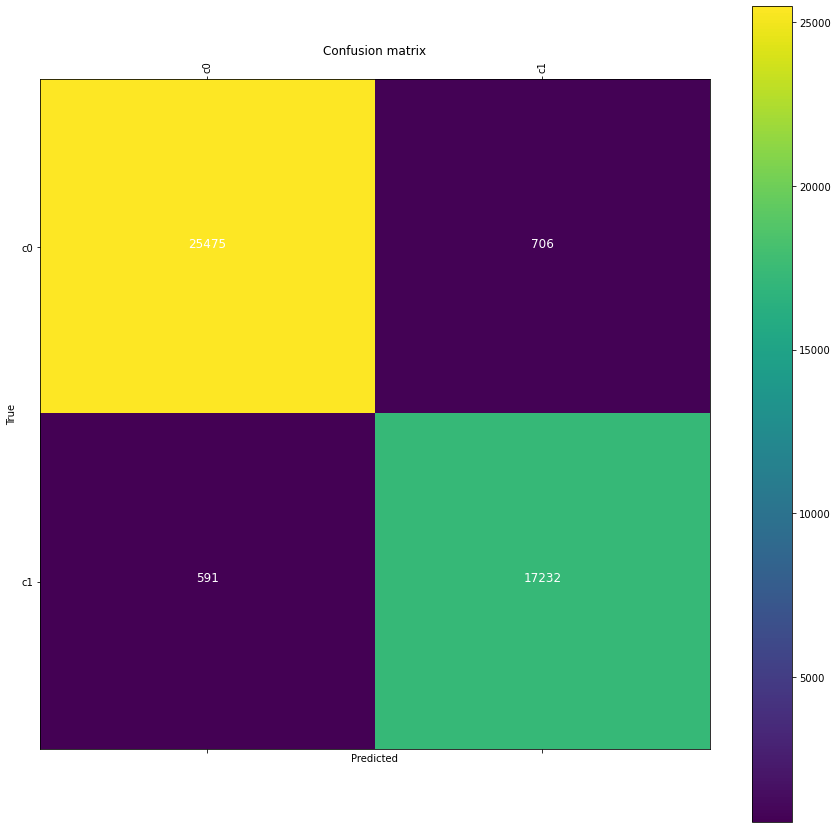

In [40]:
cm = confusion_matrix(val_labels, predictions3)
plot_cm(cm)